<a href="https://colab.research.google.com/github/hungngo97/Sparse-Regression/blob/master/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# BZ dataset: https://scipython.com/blog/simulating-the-belousov-zhabotinsky-reaction/
# STEP2: Sparse Regression
# TODO: Read Kutz's notes

# STep3: KL divergence
# https://bigdatascientistblog.wordpress.com/2017/09/11/a-simple-introduction-to-kullback-leibler-divergence-through-python-code/

# tep4: AIC BIC
# https://www.reddit.com/r/statistics/comments/5h2rbw/does_python_have_a_package_for_aicbic/
# https://en.wikipedia.org/wiki/Akaike_information_criterion
#   https://en.wikipedia.org/wiki/Bayesian_information_criterion

# Section 1: Reading data set concerning Canadian lynx and snowshoe hare populations from 1845 to 1903.
The given data is in .mat file so it is more complicated to read data from
#1.1: Google Auth Permission to Access Google Drive


In [0]:
# Code to read csv file into Colaboratory:

!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [3]:
filenames = ['BZ.mat', 'population.mat']
links = ['https://drive.google.com/open?id=1MT9PgT8iItCGyD3zUgcG3kLjDaAp2Wnw',
         'https://drive.google.com/open?id=1r9Hg_rwMie2tC8UuqE3gAURABFPkn-VZ']
for index, filename in enumerate(filenames):
  _, id = links[index].split('=')
  print (id) # Verify that you have everything after '='
  downloaded = drive.CreateFile({'id':id}) 
  downloaded.GetContentFile(filename)

1MT9PgT8iItCGyD3zUgcG3kLjDaAp2Wnw
1r9Hg_rwMie2tC8UuqE3gAURABFPkn-VZ


In [4]:
!pip install hdf5storage
import hdf5storage
mat = hdf5storage.loadmat(filenames[0])

In [0]:
BZ_tensor = mat['BZ_tensor']
# Shape = (351, 451, 1200)

In [0]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import time
m,n,k=BZ_tensor.shape # x vs y vs time data

#m by n is too big, therefore we can try to crop it
row_start = 150
row_end = 200
column_start = 200
column_end = 250
def plot_timestep(timestep):  
  A=BZ_tensor[:,:,timestep]
  plt.imshow(A)
  plt.colorbar(orientation="horizontal", pad=0.2)
def plot_timestep_cropped(timestep):  
  A=BZ_tensor[row_start: row_end,column_start:column_end,timestep]
  plt.imshow(A)
  plt.colorbar(orientation="horizontal", pad=0.2)

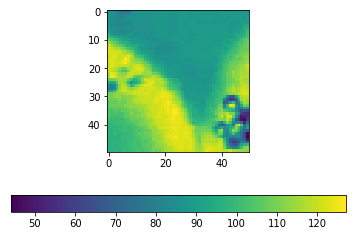

In [10]:
plot_timestep_cropped(200)

In [0]:
X = None
k = 100
# row_start = 0
# row_end = m
# colummn_start = 0
# column_end = n


for t in range(k):
  X_t = BZ_tensor[row_start: row_end,column_start:column_end,t]
  x = np.zeros((1,n))
  for i in range(row_end - row_start):
    x = np.concatenate((x, X_t[i,:]),axis=None)
  if X is None:
    X = x
  else:
    X = np.vstack((X, x))

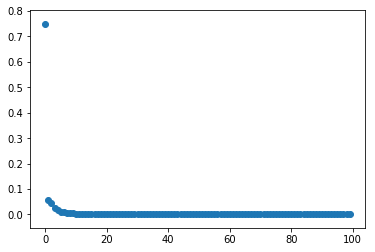

In [18]:
# TODO: Try to perform SVD?
X = np.transpose(X)
[u,s,v]= np.linalg.svd(X, full_matrices=False)
plt.scatter(range(s.shape[0]), s/(np.sum(np.diag(s))))
#TODO: Data should be in the shape of each column is a state in 1 timestep and 
# columns by columns are next timesteps. aka (1 timestep = 1 column)
# Udot = np.transpose(Xdot)     
# Udot = np.reshape(Udot, n*m*(k - 2), 1)

In [0]:
dt= 1; #Not sure
m,n = X.shape; 

Xdot = np.zeros((m, n - 2))
for jj in range(m):
  for j in range(1, n - 1):
    Xdot[jj, j - 1] = (X[jj, j + 1] - X[jj, j - 1]) / (2 * dt)


# Xdot=zeros(m,n-2);
# for jj=1:m  % walk through rows (space)
# for j=2:n-1  % walk through time
#    Xdot(jj,j-1)=( X(jj,j+1)-X(jj,j-1) )/(2*dt);
# end
# end

# u=reshape( X(:,2:end-1).',(n-2)*m ,1 );

# for jj=2:n-1
#    ux(jj-1,:)=((D*X(:,jj)).');  % u_x
#    uxx(jj-1,:)=((D2*X(:,jj)).');  % u_xx
#    u2x(jj-1,:)=((D* (X(:,jj).^2) ).');  % (u^2)_x
# end

# Ux=reshape(ux,(n-2)*m,1);
# Uxx=reshape(uxx,(n-2)*m,1);
# U2x=reshape(u2x,(n-2)*m,1);

# A=[u u.^2 u.^3 Ux Uxx U2x Ux.*u Ux.*Ux Ux.*Uxx];

# Udot=reshape((Xdot.'),(n-2)*m,1);
# %xi=A\Udot;
# xi=lasso(A,Udot,'Lambda',0.002);
# bar(xi)






In [0]:
# Derivative matrix
dx = np.add(np.subtract(X[:,0], X[:, 1]), 1e-1)
dx = dx.reshape((-1, 1))
# % derv matrices
# dx=x(2)-x(1);

D = np.zeros((m, m)) # m by m is too big 
D2 = np.zeros((m, m))

for j in range(m - 1):
  D[j, j + 1] = 1
  D[j + 1, j] = -1
  D2[j, j + 1] = 1
  D2[j + 1, j] = 1
  D2[j, j] = -2


In [0]:
D[m - 1, 0] = 1
D[0, m - 1] = -1
D = (1 / (2 * dx)) * D
D2[m - 1, m - 1] = -2
D2[m - 1, 0] = 1
D2[0, m - 1] = 1
D2 = D2 / (np.power(dx, 2))


In [0]:
u = np.reshape( np.transpose(X[:, 1:n -1]), ((n - 2) * m, 1))
# u=reshape( X(:,2:end-1).',(n-2)*m ,1 );

ux = np.zeros((n - 2, m))
uxx = np.zeros((n - 2, m))
u2x = np.zeros((n - 2, m))
for jj in range(1, n - 1):
  currentState = np.reshape(X[:, jj], (-1, 1))
  ux[jj - 1, :] = (np.transpose((np.matmul(D,currentState))))
  uxx[jj - 1, :] = (np.transpose(np.matmul(D2, currentState)))
  uxx[jj - 1, :] = (np.transpose(np.matmul(D,(np.power(currentState, 2)))))

# for jj=2:n-1
#    ux(jj-1,:)=((D*X(:,jj)).');  % u_x
#    uxx(jj-1,:)=((D2*X(:,jj)).');  % u_xx
#    u2x(jj-1,:)=((D* (X(:,jj).^2) ).');  % (u^2)_x
# end

ux = np.reshape(ux, ((n - 2 * m) , 1))
uxx = np.reshape(uxx, ((n - 2 * m) , 1))
u2x = np.reshape(u2x, ((n - 2 * m) , 1))

# A=[u u.^2 u.^3 Ux Uxx U2x Ux.*u Ux.*Ux Ux.*Uxx];
u2 = np.power(u,2)
u3 = np.power(u,3)
u4 = np.power(u, 4)
ux2 = np.power(ux, 2)
ux3 = np.power(ux, 3)
uux = np.multiply(ux, u)
uxux = np.multiply(ux,ux)
uxuxx = np.multiply(ux, uxx)
A = np.array([u, u2, u3, u4, ux, ux2, ux3,  uxx, u2x, uux, uxux, uxuxx])[:,:,0]
library = A.shape[1]
Udot = np.reshape(np.transpose(Xdot), ((n - 2) * m, 1))
# Udot=reshape((Xdot.'),(n-2)*m,1);


In [100]:
from sklearn import linear_model

# A x = b
# b = (289198,1)
# A = (9, 289198)
# (289198, 9) * (9, 1) = (289198, 1)
#Lasso
A = np.transpose(A)
clf_lasso_BZ = linear_model.Lasso(alpha=0.5)
clf_lasso_BZ.fit(A[()], Udot)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Lasso(alpha=0.5, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

<BarContainer object of 12 artists>

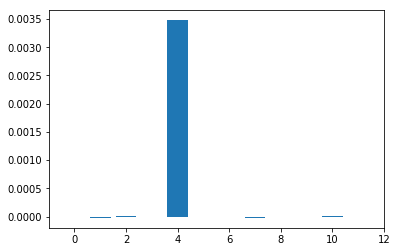

In [106]:
plt.bar(range(12), clf_lasso_BZ.coef_)

# Part 1: Predator-Prey Model


In [0]:
from scipy.io import loadmat

data = loadmat('population.mat')

In [0]:
x1 = data['hare']
x2 = data['lynx']
t = data['year']
dt=2
x0=[x1[0] , x2[0]]

Since the data space is too small to fit a Lasso regression, which might lead to overfitting the data, we need to augment more data by interpolating new data from existing data points using a curve fit interpolation from Scipy

In [0]:
from scipy.interpolate import interp1d
f_hare = interp1d(t.squeeze(), x1.squeeze(), kind='cubic')
f_lynx = interp1d(t.squeeze(), x2.squeeze(), kind='cubic')
t = np.linspace(1845, 1903, num=120, endpoint=True)
x1 = f_hare(t)
x2 = f_lynx(t)
x1 = np.reshape(x1,(-1, 1))
x2 = np.reshape(x2, (-1, 1))
plt.plot(t,x1,t,x2)

In [0]:
n= t.size
x1dot = np.zeros((n-2,1))
x2dot = np.zeros((n-2,1))
for j in range(1,n-1):
  x1dot[j-1]=(x1[j+1]-x1[j-1])/(2*dt)
  x2dot[j-1]=(x2[j+1]-x2[j-1])/(2*dt)

x1s=x1[1:n-1]
x2s=x2[1:n-1]
A=np.array([x1s, x2s, np.power(x1s,2), np.multiply(x1s,x2s), np.power(x2s,2),
            np.power(x1s,3), np.multiply(np.power(x2s,2), np.power(x1s,2)), 
            np.power(x2s,3)])[:,:,0]
A = np.transpose(A)


In [0]:
from sklearn import linear_model

# A x = b
# b = (28,1)
# A = (8, 28)
# (8, 28) *    (8, 1)   = (28,1)
#Lasso
clf_lasso_x1 = linear_model.Lasso(alpha=0.5)
clf_lasso_x1.fit(A[()], x1dot)

In [0]:
plt.bar(range(8), clf_lasso_x1.coef_)

In [0]:
clf_lasso_x2 = linear_model.Lasso(alpha=0.5)
clf_lasso_x2.fit(A[()], x2dot)
plt.bar(range(8), clf_lasso_x2.coef_)

In [0]:
coefficients = clf_lasso_x1.coef_.argsort()[-3:][::-1] #Get index of top 3 values
y_predicted = np.zeros((118, 1))
for index in coefficients:
  print(index)
  y_predicted = np.add(y_predicted, np.reshape(A[:, index]*  clf_lasso_x1.coef_[index], (-1, 1)))


In [0]:
plt.plot(t[1:120-1], y_predicted, t[1:120-1], x1[1:120-1])

In [0]:
from scipy import stats
print (stats.entropy(pk=x1[1:120-1], qk=y_predicted))

In [0]:
# TODO: checkout this AIC BIC formulas
# https://www.mathworks.com/matlabcentral/answers/195674-neural-network-aic-and-bic-calculation-number-of-parameters
# AIC, BIC calculation
resid = x1[1:120-1] - y_predicted
sse = sum(resid**2)
k= 3
AIC= 2*k - 2*np.log((sse))
n = 118
BIC = n*np.log(sse/n) + k*np.log(n)
print(AIC)
print(BIC)

#Perform Time-Delayed Embeddings

In [0]:
# H=[x1[0:110],
#    x1[1:111],
#    x1[2:112],
#    x1[3:113],
#    x1[4:114],
#    x1[5:115],
#    x1[6:116],
#    x1[7:117]];

def build_hankel_matrix(x, layers):
  size = x.shape[0]
  H = np.zeros((1, size - layers)) #(1, 107)
#   print("From \t To")
  for i in range(layers):
#     print(str(i) + "\t " + str(size - layers + i))
    H = np.vstack((H, np.transpose(x1[i : size - layers + i])))
  return H

layers = 50
H = build_hankel_matrix(x1, layers)
[u,s,v]= np.linalg.svd(H)
plt.scatter(range(layers + 1), s/(np.sum(np.diag(s))))

H2 = build_hankel_matrix(x2, layers)
[u,s,v]= np.linalg.svd(H2)
plt.scatter(range(layers + 1), s/(np.sum(np.diag(s))))





# figure(6), plot(300*v(:,4),'Linewidth',[2])
# hold on
# plot(x(1:5000))

In [0]:
plt.plot(u[:,1:5])

In [0]:
from mpl_toolkits import mplot3d
ax = plt.axes(projection='3d')
# plt.plot3(v[:,1],v[:,2],v[:,3])
ax.plot3D(v[:,1],v[:,2],v[:,3], 'gray')
ax.scatter3D(v[:,1],v[:,2],v[:,3], c=v[:,3], cmap='Greens');